# HW 4: Text Data & Neutral Networks 
## Name: Jeonseo David Lee (UNI: jl6569)

In [72]:
pip install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.cluster import hierarchy

## <Part 1> 
## Import the text data, vectorize the clickbait headline column into an X matrix.  Then run logistic regression at least three times and select a single best model.  Note that you should create three logistic regression models with different different tokenization approaches.  You should not change your modeling approach, you should simply experiment with different tokenizers. Be sure to explain your choices and evaluate your models using cross validation and using test set data.



 

### - We are developing a text classification model in which the term "clickbait" is either present or not. I have employed three distinct tokenization approaches for logistic regression after separating the training and test datasets. The three versions are comprised of CountVectorizer, TfidVectorizer, and NLTK Tokenizer. Each approach possesses different strengths, with CountVectorizer being particularly advantageous due to its simplicity in detecting words based on their frequencies within the text. TfidVectorizer has a little different usage where it is often preferred when we want to account for the words' uniqueness in the texts on top of their frequencies. Lastly, the NLTK tokenizer is useful when we need more sophisticated tokenization, especially if we are working with tasks that require understanding sentence structure, part-of-speech tagging, or other linguistic analyses.

### - Although the features chosen from the visualization using the 'visualize_coefficients' function offered in the lecture are not identical across all models, they do share certain similarities. The predicted outcome is positively correlated with characteristics that have positive coefficients. The magnitude of the feature's impact increases with the magnitude of the positive coefficient. It is clear that such features as "salad," "roommates," and "disorder" exhibit substantial positive coefficients across all three models. Conversely, the features like "experts," "astronomers," and "lobbyists" are all represented by negative coefficients.  

### - Given understanding the subtle differences between the approaches and the fact that each model is properly evaluated via visualizations, we can now decide which model to choose by analyzing the results. Each model underwent a gridsearchCV process in which the parameters "C" (regularization) and "max_iter" (the number of iterations) were selected as {'C':1, 'max_iter': 10}. The accuracy scores on the test set follow the order: NLTK Tokenizer (approximately 0.762%), CountVectorizer (approximately 0.754%), and TfidVectorizer (approximately 0.751%). Hence, I would select the NLTK Tokenizer as my model in order to achieve the highest possible accuracy score on the test set.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [24]:
X_train = pd.read_csv("X_train.csv")
y_train_label = pd.read_csv("y_train.csv")
print(X_train.head())
print(y_train_label.head())


                                            headline
0     MyBook Disk Drive Handles Lots of Easy Backups
1                     CIT Posts Eighth Loss in a Row
2  Candy Carson Singing The "National Anthem" Is ...
3  Why You Need To Stop What You're Doing And Dat...
4  27 Times Adele Proved She's Actually The Reale...
           label
0  not clickbait
1  not clickbait
2      clickbait
3      clickbait
4      clickbait


In [25]:
# One hot coding for the y_train labels 
y_train = pd.get_dummies(y_train_label['label'])
y_train = y_train['clickbait']


y_train = np.array(y_train) 
X_train = np.array(X_train)

# Making it a 1D array 
X_train = X_train.flatten()
X_train = np.array(X_train, dtype=str)

### 1) First Tokenizer Method: CountVectorizer 

In [26]:
# CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english', min_df = 1, max_df =5)
X_train_vec = count_vectorizer.fit_transform(X_train)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_vec = scaler.fit_transform(X_train_vec.toarray())


# Split the data into training and test sets
X_train, X_test, y_train, y_test  = train_test_split(X_train_vec, y_train, test_size=0.2, random_state=42)

In [27]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'max_iter': [10, 100, 1000, 5000]}

grid = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Performance on the test set: {:2f}".format(grid.score(X_test, y_test)))

/Users/jeonseo/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best cross-validation score: 0.74
Best parameters:  {'C': 1, 'max_iter': 10}
Performance on the test set: 0.753634


In [7]:
# helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")



/Users/jeonseo/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


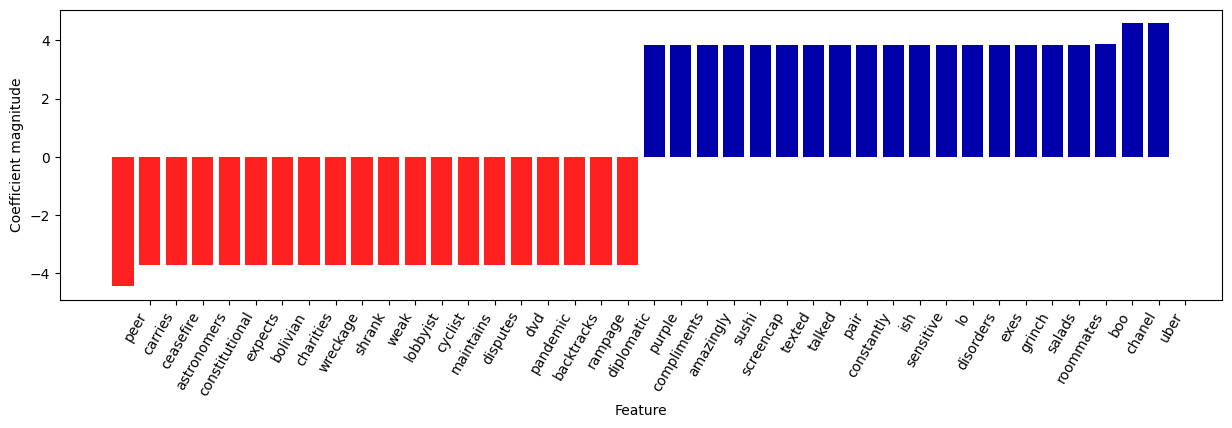

In [8]:
coefs = LogisticRegression(C=10, max_iter = 10).fit(X_train,y_train).coef_
feature_names = count_vectorizer.get_feature_names_out()

visualize_coefficients(coefs, feature_names, n_top_features=20)

### 2) Second Tokenizer Method: TfidVectorizer

In [9]:
X_train = pd.read_csv("X_train.csv")
y_train_label = pd.read_csv("y_train.csv")

# One hot coding for the y_train labels 
y_train = pd.get_dummies(y_train_label['label'])
y_train = y_train['clickbait']


y_train = np.array(y_train) 
X_train = np.array(X_train)

# Making it a 1D array 
X_train = X_train.flatten()
X_train = np.array(X_train, dtype=str)

In [10]:
# CountVectorizer
tfid_vectorizer = TfidfVectorizer(stop_words="english", min_df = 1, max_df = 5)
X_train_tfid = tfid_vectorizer.fit_transform(X_train)

# Split the data into training and test sets
X_train, X_test, y_train, y_test  = train_test_split(X_train_tfid, y_train, test_size=0.2, random_state=42)

In [11]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'max_iter': [10, 100, 1000, 5000]}

grid = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Performance on the test set: {:2f}".format(grid.score(X_test, y_test)))

Best cross-validation score: 0.74
Best parameters:  {'C': 1, 'max_iter': 10}
Performance on the test set: 0.750734


/Users/jeonseo/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


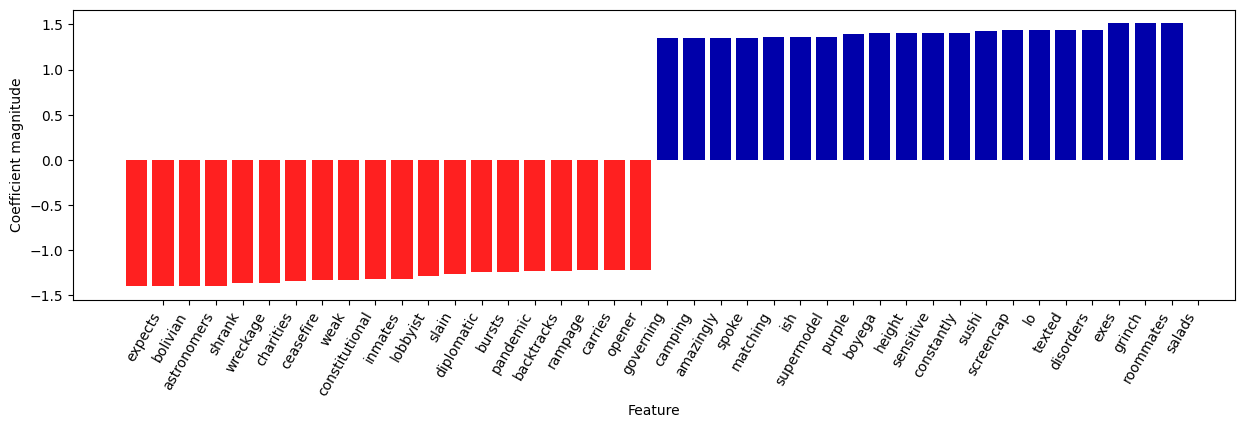

In [12]:
coefs = LogisticRegression(C=1, max_iter = 10).fit(X_train,y_train).coef_
feature_names = tfid_vectorizer.get_feature_names_out()

visualize_coefficients(coefs, feature_names, n_top_features=20)

### 3) Third Tokenizer Method: NLTK Tokenizer 

In [13]:
X_train = pd.read_csv("X_train.csv")
y_train_label = pd.read_csv("y_train.csv")

# One hot coding for the y_train labels 
y_train = pd.get_dummies(y_train_label['label'])
y_train = y_train['clickbait']


y_train = np.array(y_train) 
X_train = np.array(X_train)

# Making it a 1D array 
X_train = X_train.flatten()
X_train = np.array(X_train, dtype=str)

In [14]:
from nltk.tokenize import word_tokenize

def nltk_tokenizer(text):
    return word_tokenize(text)

In [15]:
nltk_vectorizer = CountVectorizer(tokenizer=nltk_tokenizer, stop_words="english", min_df = 1, max_df = 5)
X_train_nltk = nltk_vectorizer.fit_transform(X_train)

# Split the data into training and test sets
X_train, X_test, y_train, y_test  = train_test_split(X_train_nltk, y_train, test_size=0.2, random_state=42)

/Users/jeonseo/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'max_iter': [10, 100, 1000, 5000]}

grid = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid, cv=5, scoring = 'roc_auc')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Performance on the test set: {:2f}".format(grid.score(X_test, y_test)))

/Users/jeonseo/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best cross-validation score: 0.75
Best parameters:  {'C': 1, 'max_iter': 10}
Performance on the test set: 0.761727


/Users/jeonseo/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


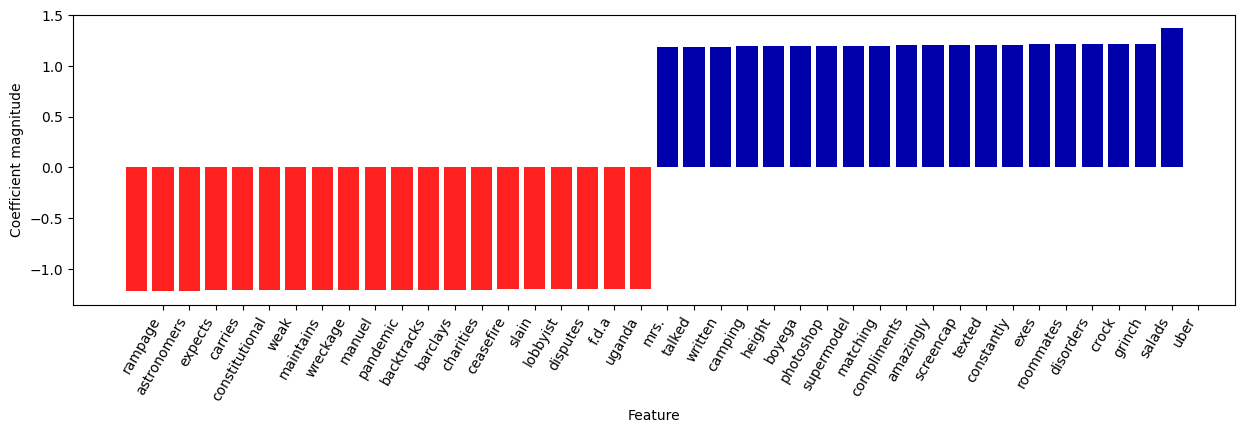

In [17]:
coefs = LogisticRegression(C=1, max_iter = 10).fit(X_train,y_train).coef_
feature_names = nltk_vectorizer.get_feature_names_out()

visualize_coefficients(coefs, feature_names, n_top_features=20)

## <Part 2: Build a predictive neural network using Keras> 
## Train test split the iris dataset and then run a multilayer perceptron (feed forward neural network) with two hidden layers on the iris dataset using the keras Sequential interface. Fit two models with different numbers of hidden layers and or hidden neurons and evaluate each on a test-set.  Describe the differences in the predictive accuracy of models with different numbers of hidden units/neurons.  Describe the predictive strength of your best model.  Be sure to explain your choice and evaluate this model using the test set.

### - I had split the iris data with Y representing the species label where it has 3 categories: setosa, versicolor, and virginica. Then, I've made two models, each with a different number of hidden layers and neuron counts where the model 1 has two hidden layers, and the model 2 has three hidden layers. The initial dense layer is set to 4, as our dataset contains the following four features: Sepal.Length, Sepal.Width, Petal.Length, and Petal.Width.

### - The activation methods'relu' and'softmax' have been incorporated into both models. For the output layer,'softmax' is utilized due to the multi-classification nature of the problem, which involves outcome variables exceeding two. To mirror the model's capability of multi-classification, I have also specified the loss function as "categorical_crossentropy" during model compilation. 

### - Model 2 provides fewer loss values and a higher accuracy score than model 1. This indicates that the model achieves greater success in reducing loss and improving accuracy with each additional hidden layer. The scores of model 1 are as follows: [Test Loss: 0.46; Test Accuracy: 0.83]; in contrast, model 2 has the following scores: [Test Loss: 0.34; Test Accuracy: 0.93]. Based on the findings, a more intricate model that attains superior accuracy and lower loss may indicate that model2 is capitalizing on its enhanced capability to detect complex patterns within the data; an accuracy of 0.93 (or 93%) indicates that the model 2 correctly classified 93% of the instances in the test data, and the value of 0.34 in loss suggests that the model's predictions have relatively small errors on average. The incorporation of an extra layer in model2 facilitates the model's acquisition of hierarchical representations, a feature that proves advantageous when confronted with tasks entailing complex relationships. Therefore, I would choose model 2 with four hidden layers as my model.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD

/Users/jeonseo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
iris = pd.read_csv("iris.csv", index_col=0)
iris.head()
#y = iris['Species']
y = pd.get_dummies(iris["Species"])
X = iris.loc[:, iris.columns != 'Species']

iris['Species'].value_counts()

Species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model 1

In [23]:
# Build Model 1
model1 = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax') # There must be three categories in the output layer
])

sgd = SGD(lr=0.0001) 

# Compile Model 1
model1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# Train Model 1
model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate Model 1
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

1/1 [==============================] - 0s 14ms/step - loss: 0.4655 - accuracy: 0.8333
Test Loss: 0.4654783606529236, Test Accuracy: 0.8333333134651184


#### Model 2  


In [92]:
# Build Model 2
model2 = Sequential([
    Dense(100, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(50, activation='relu'),
    Dense(30, activation='relu'),
    Dense(3, activation='softmax')
])

sgd = SGD(lr=0.0001) 

# Compile Model 2
model2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# Train Model 2
model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate Model 2
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

1/1 [==============================] - 0s 15ms/step - loss: 0.3414 - accuracy: 0.9333
Test Loss: 0.3413836359977722, Test Accuracy: 0.9333333373069763
